In [132]:
import os

from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import torch
from torchvision.utils import make_grid
from tqdm import tqdm

In [92]:
breed = "data/breed.csv"
filename = "data/labels.csv"
labelsNames = ["id", "breed"]
labels = read_csv(filename, names=labelsNames)

breedNames = read_csv(breed)["breed"].tolist()[1:]
print(labels.shape)
# print(len(breedNames))

(12001, 2)


In [21]:
le = LabelEncoder()
le.fit(list(set(labels["breed"].tolist()[1:])))
data_label = le.transform(labels["breed"].tolist()[1:])
print(len(data_label))

12000


In [22]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),  # 水平镜像
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]  # 用平均值和标准偏差归一化张量图像
            ),  # input = (input - mean) / std
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),  # 测试只需要从中间裁剪
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]  # mean
            ),  # std
        ]
    ),
}

In [23]:
from sklearn.model_selection import train_test_split

labels_files = labels["id"].apply(lambda x: os.getcwd()+"/data/train/" + x + ".jpg").tolist()[1:]
train_path, val_path, train_label, val_label = train_test_split(
    labels_files, data_label, test_size=0.2
)


In [24]:
from torch.utils.data import Dataset


class DogDataset(Dataset):
    def __init__(self, data_path, data_label, transform=None):
        """
        - data_path (string): 图片路径
        - data_label (string): 图片标签
        - transform (callable, optional): 作用在每个样本上的预处理函数
        """
        self.data_path = data_path
        self.data_label = data_label
        self.transform = transform

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img_path = self.data_path[idx]
        image = io.imread(img_path)
        label = self.data_label[idx]

        # 如果有，则对数据预处理
        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
train_dataset = DogDataset(train_path, train_label, data_transforms["train"])
val_dataset = DogDataset(val_path, val_label, data_transforms["val"])


# 训练数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 验证数据加载器
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


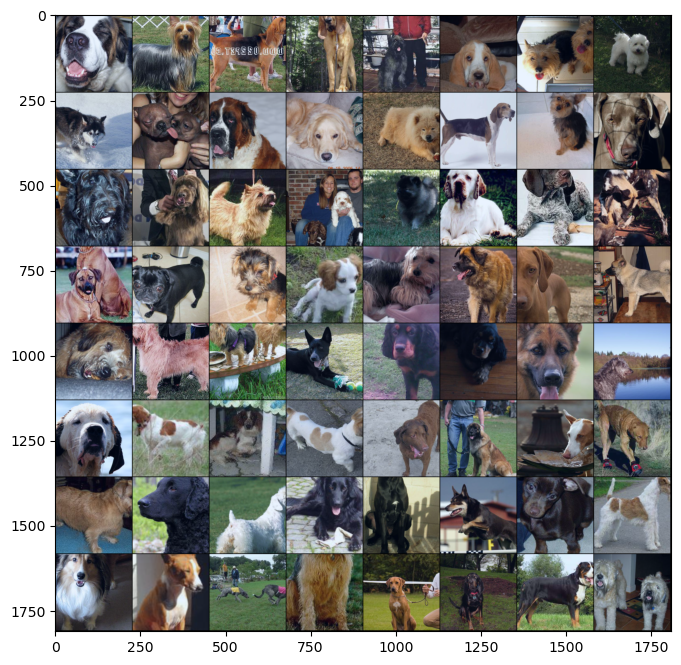

In [26]:

for batch_index, sample_batch in enumerate(train_loader):
    images, labels = sample_batch
    sample_images = make_grid(images, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_images.permute(1, 2, 0).numpy())
    break

In [27]:
from torchvision import models

# 从课程镜像服务器上下载 AlexNet 预训练模型
torch.utils.model_zoo.load_url(
    "https://cdn.aibydoing.com/aibydoing/files/alexnet-owt-4df8aa71.pth"
)
alexnet = models.alexnet(pretrained=True)
alexnet

E:\Program\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Program\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
for param in alexnet.parameters():
    param.requires_grad = False
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [44]:
classifier = list(alexnet.classifier.children())  # 读取分类器全部层
# 将最后一层由 Linear(4096, 1000) 改为 Linear(4096, 120)
classifier[-1] = torch.nn.Linear(4096, 120)
classifier.append(torch.nn.Softmax(dim=1))  # 添加 LogSoftmax 层
alexnet.classifier = torch.nn.Sequential(*classifier)  # 修改原分类器
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [45]:
dev = torch.device("cuda") 

In [46]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, alexnet.parameters()), lr=0.001
)  # 优化器
# 学习率衰减，每迭代 1 次，衰减为初始学习率 0.5
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

criterion, optimizer, lr_scheduler

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.StepLR at 0x1603b40ab20>)

In [91]:
epochs = 100
model = alexnet.to(dev)
print("Start Training...")
if os.path.exists("models/model.pt"):#是否存在预训练模型
    model_saved = alexnet
    model_saved.load_state_dict(torch.load("models/model.pt",weights_only=True))
    model = model_saved.to(dev)
    print("Load model from model.pt")

    
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(dev)  # 添加 .to(dev)
        labels = labels.to(dev)  # 添加 .to(dev)

        outputs = model(images)
        loss = criterion(outputs, labels.type(torch.int64))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if (i + 1) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}".format(
                    epoch + 1, epochs, i + 1, len(train_loader), loss.item()
                )
            )

    correct = 0
    total = 0
    if epoch % 10 == 0:
            print("Save model to model.pt")
            torch.save(model.state_dict(), "models/model.pt")
    for images, labels in val_loader:
        images = images.to(dev)  # 添加 .to(dev)
        labels = labels.to(dev)  # 添加 .to(dev)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print("============ Test accuracy: {:.3f} =============".format(correct / total))

    lr_scheduler.step()  # 设置学习率衰减

Start Training...
Load model from model.pt
Epoch [1/100], Batch [100/150], Train loss: 3.939
Save model to model.pt
============ Test accuracy: 0.580 =============
Epoch [2/100], Batch [100/150], Train loss: 4.114
============ Test accuracy: 0.576 =============
Epoch [3/100], Batch [100/150], Train loss: 4.040
============ Test accuracy: 0.571 =============
Epoch [4/100], Batch [100/150], Train loss: 4.061
============ Test accuracy: 0.586 =============
Epoch [5/100], Batch [100/150], Train loss: 3.971
============ Test accuracy: 0.575 =============
Epoch [6/100], Batch [100/150], Train loss: 4.005
============ Test accuracy: 0.579 =============
Epoch [7/100], Batch [100/150], Train loss: 3.974
============ Test accuracy: 0.575 =============
Epoch [8/100], Batch [100/150], Train loss: 4.029
============ Test accuracy: 0.580 =============
Epoch [9/100], Batch [100/150], Train loss: 4.054
============ Test accuracy: 0.583 =============
Epoch [10/100], Batch [100/150], Train loss: 4.064
=

In [90]:
torch.save(model.state_dict(), "models/model.pt")

In [79]:
IMAGE = io.imread("data/train/0AjbbdBwNiGqWo5n.jpg")
IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)  # PyTorch 模型输入必须为 B*C*H*W
IMAGE.size()

torch.Size([1, 3, 224, 224])

In [113]:
data= model_saved(IMAGE.to(dev))
# probality = model_saved(IMAGE.to(dev))
# print(probality)
# print(le.inverse_transform([data]))
tempDict = {}
for i in range(len(data[0])):
    tempDict[le.inverse_transform([i])[0]] = data[0][i].item()
temp=pd.DataFrame(tempDict,index=[0])
temp.insert(0,"id","0AjbbdBwNiGqWo5n")
temp

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0AjbbdBwNiGqWo5n,1.406047e-12,5.810765e-12,8.083837e-12,1.228350e-15,0.000049,1.400323e-14,7.939518e-14,0.001354,3.320112e-09,...,9.231948e-15,1.647737e-07,2.510706e-10,1.946432e-09,0.000713,5.515877e-11,1.248934e-11,0.168964,5.071975e-11,8.244077e-16


,id,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [134]:
outdata= pd.DataFrame(columns=["id"]+breedNames)
outdata
testPath = os.getcwd()+"/data/test/"
files= os.listdir(testPath)

p=0

for file in tqdm(files):
    p+=1
    IMAGE = io.imread(testPath+file)
    IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)
    data= model_saved(IMAGE.to(dev))
    tempDict = {}
    for i in range(len(data[0])):
        tempDict[le.inverse_transform([i])[0]] = data[0][i].item()
    temp=pd.DataFrame(tempDict,index=[0])
    temp.insert(0,"id",file[:-4])
    outdata=pd.concat([outdata,temp],ignore_index=True)
outdata

100%|██████████| 8580/8580 [05:56<00:00, 24.08it/s]


,id,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier,affenpinscher
0,008Zz1GNSbRNaqqj,4.913340e-14,6.745603e-13,7.928386e-16,1.857481e-07,2.516983e-16,1.542097e-16,1.173035e-06,8.507361e-12,2.090903e-12,...,1.052768e-10,8.977761e-10,4.939372e-12,5.288469e-05,2.348282e-14,1.610769e-14,1.249516e-03,2.221434e-15,3.049509e-19,3.633348e-13
1,00wd05Btck908VRT,5.776395e-04,2.914907e-13,1.332534e-11,5.583092e-16,9.054333e-10,1.930451e-05,9.335438e-11,1.667744e-09,1.900769e-09,...,7.828395e-12,7.504282e-15,4.275100e-12,1.495870e-14,3.336995e-10,6.186641e-09,6.140765e-10,8.283402e-11,1.469054e-03,8.749339e-02
2,02Qx6hgcRoBUHq5b,2.368381e-02,8.416092e-12,5.029478e-08,1.430582e-12,3.849763e-10,2.974098e-08,1.271955e-11,8.029623e-11,2.252572e-11,...,6.998230e-16,1.035793e-11,2.992628e-14,1.570514e-14,8.216690e-10,2.690675e-11,8.712516e-11,3.648511e-11,1.441501e-10,2.522519e-05
3,04UkFuz25SHPvfrR,8.670220e-14,2.012242e-16,4.410880e-15,1.547845e-05,1.630724e-10,4.454742e-16,4.093861e-09,5.922637e-05,6.193697e-01,...,2.529116e-08,1.727310e-10,6.495243e-02,4.979539e-12,1.347856e-05,9.927551e-18,3.381504e-09,8.920507e-12,2.422969e-18,4.290258e-19
4,05vHHSXo0wrdYikD,1.034737e-13,3.129899e-16,6.832195e-20,6.221536e-15,1.408787e-13,4.267027e-14,9.882761e-17,2.205029e-20,2.225661e-13,...,5.426764e-09,4.290753e-21,4.196532e-14,4.860449e-20,4.246712e-14,3.743167e-14,3.203204e-17,2.186556e-12,1.536574e-09,2.750655e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8575,Zzn2cDCzNuM5INbL,3.076162e-08,1.692059e-03,5.011105e-07,2.131432e-04,3.064513e-07,7.082001e-08,4.853263e-03,7.431793e-05,2.744105e-03,...,1.269810e-03,9.516601e-05,9.705891e-05,4.424263e-05,5.372262e-05,3.072261e-07,2.198722e-03,1.686832e-07,1.639305e-07,1.326577e-10
8576,ZZR8wJ4LKM7PAH0M,2.469213e-24,1.000000e+00,1.475840e-25,1.729139e-21,6.198449e-22,6.700486e-22,6.578805e-24,6.419869e-23,5.802905e-21,...,7.845619e-23,2.392403e-24,1.137933e-26,1.501519e-18,2.214896e-28,1.993553e-30,5.833711e-14,4.455156e-27,1.190476e-25,8.579383e-20
8577,ZzTgk96KJevxjbl7,1.047279e-17,9.077438e-22,5.966834e-16,4.406769e-25,1.591612e-25,9.983383e-01,2.715682e-22,6.164300e-24,6.867134e-22,...,4.901764e-24,6.742285e-28,1.675357e-29,1.060071e-28,2.765686e-22,6.668837e-12,5.597994e-23,1.149273e-15,8.355337e-05,4.805216e-12
8578,ZZtsTPSPqsAe39Rp,1.071346e-07,1.058175e-12,5.208527e-06,1.745694e-05,2.991457e-13,1.249856e-09,1.393486e-08,1.919593e-09,1.013328e-04,...,1.598739e-06,4.506542e-08,1.865054e-08,3.879153e-07,2.526830e-06,2.286604e-07,7.452546e-07,2.084667e-03,2.378643e-08,7.866758e-11


In [138]:
output_path = "output.csv"  # 你可以指定任何你想要的文件路径
columns_sorted = ["id"] + sorted(col for col in outdata.columns if col != "id")
outdata = outdata[columns_sorted]
outdata.to_csv(output_path, index=False)  # index=False 表示不保存索引列